# Titanic Analysis

The goal 🎯 of this jupyter Notebook is to explore different machine learning or deep learning algorithms in order to obtain an accuracy score higher than 85% in the prediction of the people who survived or not in the titanic accident. Link to the exercise:
- [Link]([Link](https://www.kaggle.com/c/titanic))

In [1]:
#Pandas to work with Dataframe and numpy for array (np)
import pandas as pd
import numpy as np

#Seaborn and matplotlib for dataviz
import seaborn as sns
import matplotlib.pyplot as plt

#Machine learning library to make prediction, features transformation and results analysis
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Tensorflow for Deep learning
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import models

#Import utils methods
import sys
sys.path.append('..')
from Function.utils import get_title
from Function.utils import check_all_group
from Function.utils import class_of_people_by_age_sex


## Titanic Dataset exploration

In [29]:
# Load dataset
titanic_df = pd.read_csv("../Data/train.csv")
# Show Dataset first line
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


To check the description of different fields in this dataset :
>[Kaggle description of the dataset Link](https://www.kaggle.com/competitions/titanic/data)


In [30]:
# Describe data and get different information from this dataset with describe
titanic_describe = titanic_df.loc[:, titanic_df.columns != "PassengerId"].describe()
titanic_describe

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Check missing data

In [35]:
# Check the nan value in the dataset
for column in titanic_df.columns:
    print(f"{column} as {titanic_df[column].isnull().sum()} nan values")

PassengerId as 0 nan values
Survived as 0 nan values
Pclass as 0 nan values
Name as 0 nan values
Sex as 0 nan values
Age as 177 nan values
SibSp as 0 nan values
Parch as 0 nan values
Ticket as 0 nan values
Fare as 0 nan values
Cabin as 687 nan values
Embarked as 2 nan values


As we can see, Age, Cabin and Embarked have Nan value. We can check for age (because it's numerical) if this feature as a good correlation with the survived features.

In [41]:
titanic_df[["Survived","Age"]].corr(method="pearson")

,Survived,Age
Survived,1.000000,-0.077221
Age,-0.077221,1.000000


This table tell us for 1 more age the survival rate decrease to 7%. 

## Features transformation

### One Hot encoding categorical Data

We can see here that we have several categorical features:
- Survived > Binary class (0,1)
- Pclass > No Binary class (1,2,3)
- Sex > No Binary class (male, female) but easy to translate
- Maybe titles of names ? 
- Embarked > No Binary class (S, C, Q)

For this type of data we can use a one hot encoder to convert no binary class in multiple binary class.

> [Scikit Learn documentation about one hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)


    

#### Check nan values

In [4]:
titanic_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

For now nan values is only in Age and Cabin let's deal with this later 👌🏼

#### Convert Male female in binary class

In [5]:
# Transform Sex features in sex_binary, 0 if it's a man 1 if it's a girl
titanic_df["sex_binary"] = titanic_df["Sex"].apply(lambda x: 0 if x == "male" else 1)

#Drop old Sex columns 
# titanic_df.drop(columns="Sex", inplace=True)

#### Convert Pclass in binary class

In [6]:
# Declare an One Hot encoding object
ohe = OneHotEncoder(handle_unknown='ignore')
#Fit and transform on the Pclass features
encode_df = pd.DataFrame(ohe.fit_transform(titanic_df[["Pclass"]]).toarray())
#Get the columns names out of the news features (construct like names_of_old_features_className)
encode_df.columns = ohe.get_feature_names_out()
#Join news features with the titanic dataframe
titanic_df = titanic_df.join(encode_df)

#Drop old Pclass column
# titanic_df.drop(columns="Pclass", inplace=True)

In [7]:
#Check news classes
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_binary,Pclass_1,Pclass_2,Pclass_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1.0,0.0,0.0


#### Convert age features in categories

In [8]:
#Convert age in int and fill nan value with mean value of age feature
titanic_df["Age"] = titanic_df["Age"].fillna(titanic_df["Age"].mean()).astype("int")

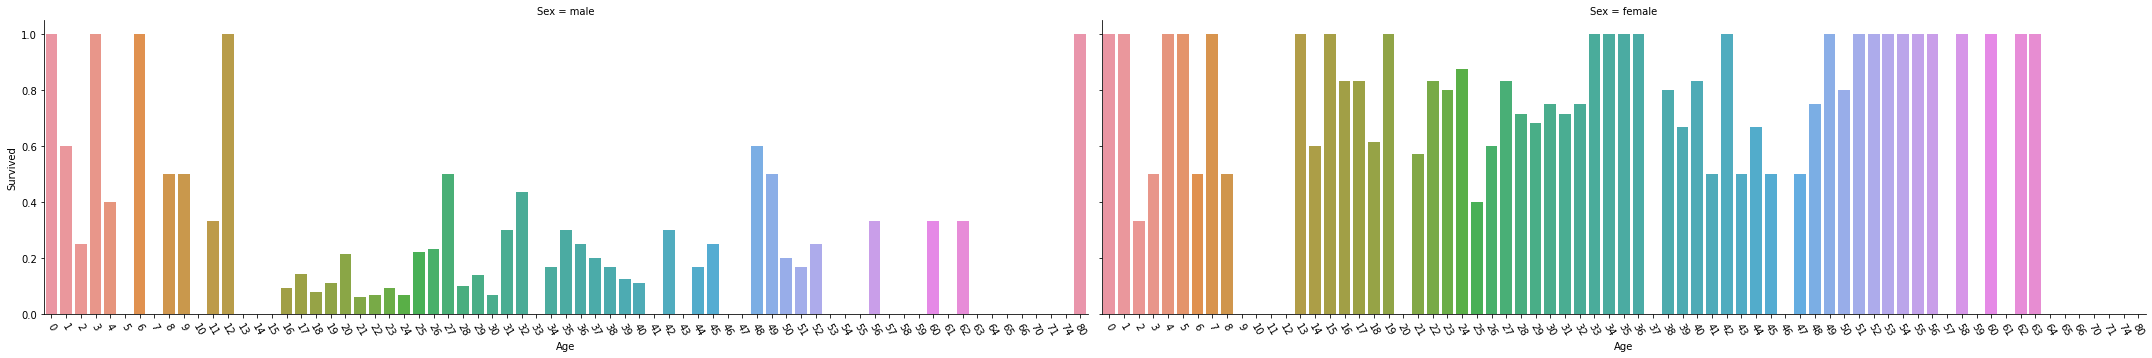

In [9]:
#Show the survival rate by ages and sex of the population
ax = sns.catplot(x="Age",y="Survived",col="Sex",data=titanic_df
    , kind="bar", ci=None, aspect=3)
#Rotate X labels for a better readability
for axes in ax.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=-60)

/Users/christopherdeboisvilliers/.pyenv/versions/lewagon/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/christopherdeboisvilliers/.pyenv/versions/lewagon/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


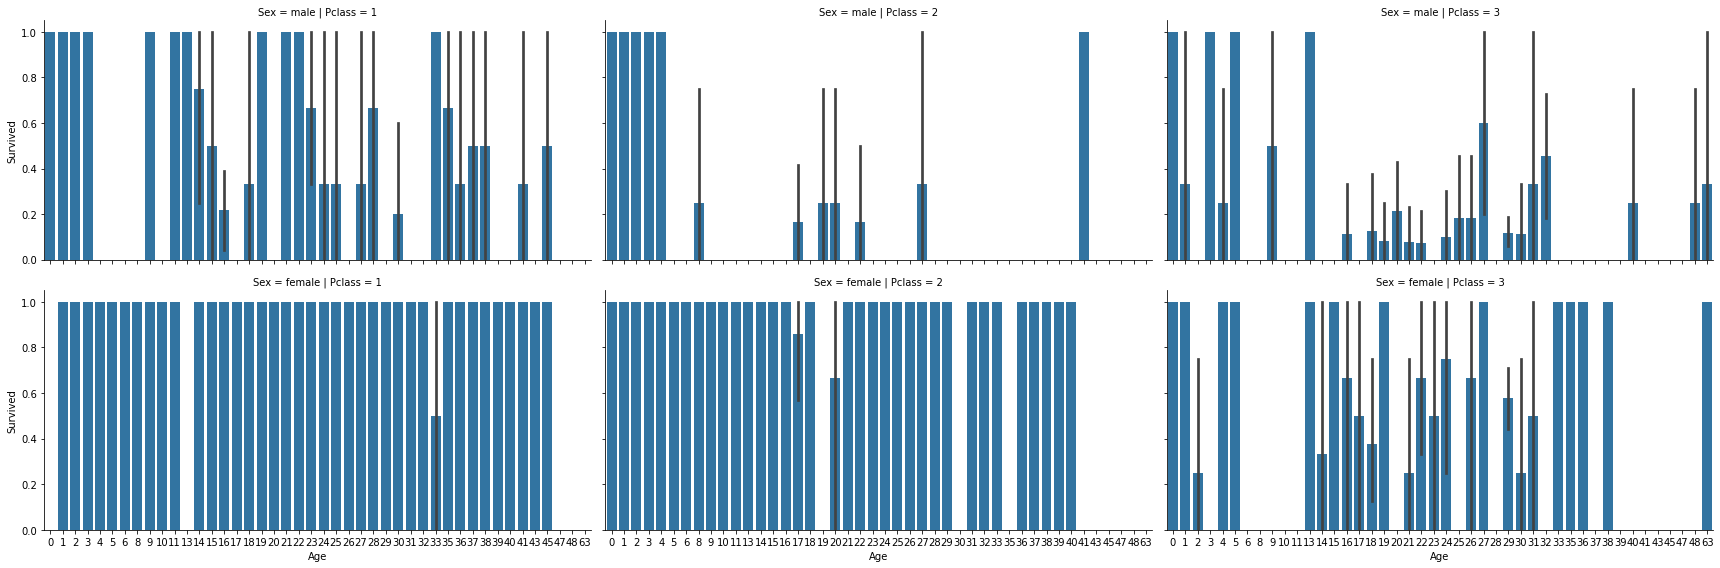

In [24]:

g = sns.FacetGrid(titanic_df, col="Pclass", row="Sex",
                  palette="Set3", size=4, aspect=2)
g.map(sns.barplot, 'Age','Survived')

Here we can see lot of things: 
1. Children (age < 12) seems to have a significant higher survival rate
2. Women with an age superior at 48 seems to have a significant higher survival rate

We can try to create 3 class: 
1. One for children 
2. One for women with an age superior at 48
3. One for the rest

It's a data exploration, after the first running model we can try improve  our score by change the classes. 

In [12]:
#Create the three different classes of people
titanic_df["Who"] = titanic_df[["Sex","Age"]].apply(lambda x : class_of_people_by_age_sex(x.Age, x.Sex), axis = 1)


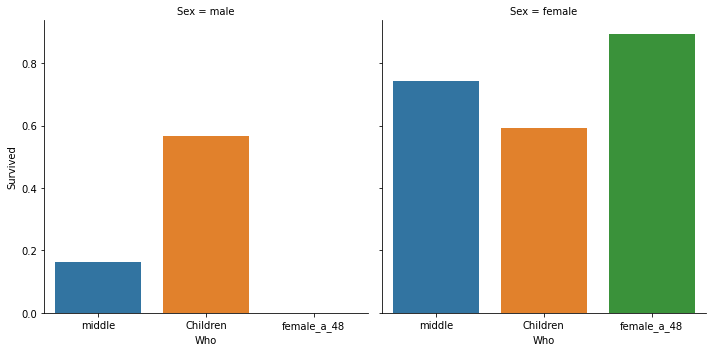

In [16]:
#Show the survival rate by new classes
ax = sns.catplot(x="Who",y="Survived",col="Sex",data=titanic_df
    , kind="bar", ci=None, aspect=1)

Now let's one hot encode this new feature

In [17]:
# Declare an One Hot encoding object
ohe = OneHotEncoder(handle_unknown='ignore')
#Fit and transform on the Who features
encode_df = pd.DataFrame(ohe.fit_transform(titanic_df[["Who"]]).toarray())
#Get the columns names out of the news features (construct like names_of_old_features_className)
encode_df.columns = ohe.get_feature_names_out()
#Join news features with the titanic dataframe
titanic_df = titanic_df.join(encode_df)

In [20]:
#Check news classes
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_binary,Pclass_1,Pclass_2,Pclass_3,Who_Children,Who_female_a_48,Who_middle
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,0,0.0,0.0,1.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,1,1.0,0.0,0.0,0.0,0.0,1.0


In [19]:
#Drop old columns 
titanic_df.drop(columns ="Who", inplace = True)

#### Check if the names of peoples contains good informations 👌🏼

We can see  in the names features different types of titles: 
- mrs
- mr
- etc

Does that titles contains any information ? 



In [22]:
#Get 
titanic_df["Name_cat"]= titanic_df["Name"].apply(lambda x : get_title(x))

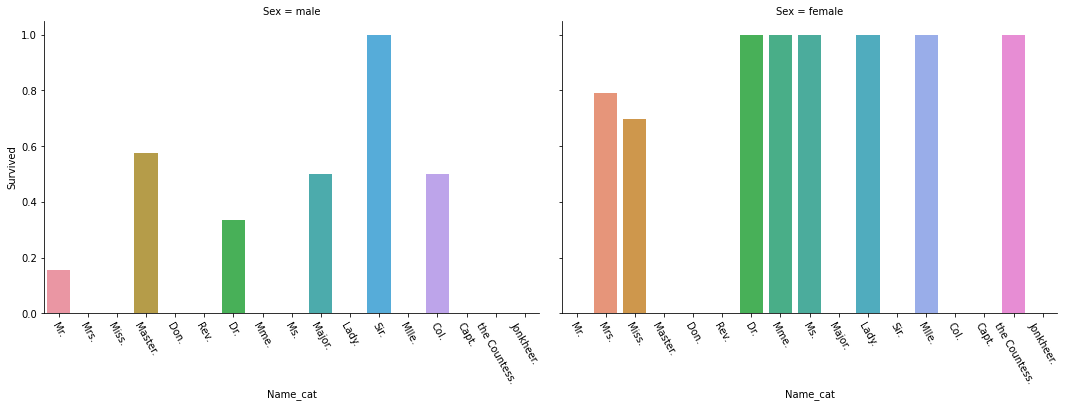

In [26]:
#Show the survival rate by Titles of peoples
ax = sns.catplot(x="Name_cat",y="Survived",col="Sex",data=titanic_df
    , kind="bar", ci=None, aspect=1.5)
#Rotate X labels for a better readability
for axes in ax.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=-60)

Yes ✅ but we cannot create an infinite number of features and one hot encode this new feature can generate 16 new features by default. 
We can agregate :
- Dr. 
- Mme.
- Lady
- Mlle
- Col
- The Countess
- Sir 

Why ? Because it contains the same information in regards to survived rate. 


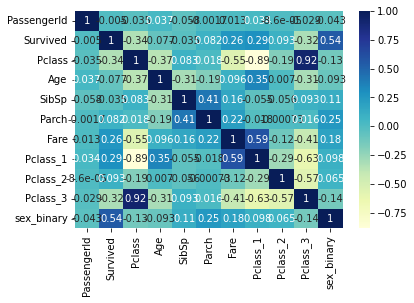

In [23]:
dataplot = sns.heatmap(titanic_df.corr(), cmap="YlGnBu", annot=True)


### Survived class repartition

In [25]:
titanic_df[["Survived"]].value_counts()

Survived
0           549
1           342
dtype: int64

We can see here the target class is unbalance:
| Survived | 0   | 1   |
|----------|-----|-----|
|          | 549 | 342 |

In [49]:
titanic_df["Name_cat"]= titanic_df["Name"].apply(lambda x : get_title(x))

<AxesSubplot:xlabel='Fare'>

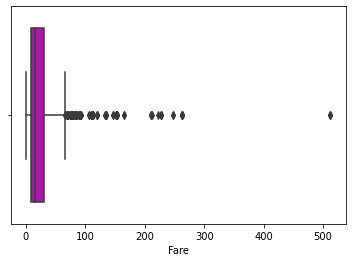

In [13]:
sns.boxplot(x="Fare",
            hue="Survived", palette=["m", "g"],
            data=train_df)

In [15]:
train_df["Who"]= train_df[["Sex","Age"]].apply(lambda x : "Children" if x.Age <= 16  else x.Sex, axis = 1)

In [11]:
len(train_df[train_df["Fare"]>80])

74

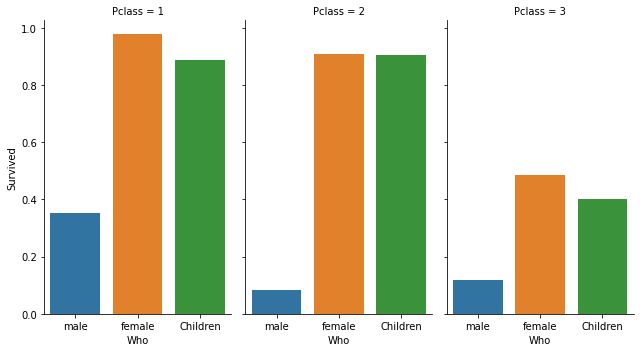

In [16]:
#Check survive rate by class and Sex (male, Female, Children)
sns.catplot(x="Who",y="Survived",col="Pclass",data=train_df
    , kind="bar", ci=None, aspect=.6)

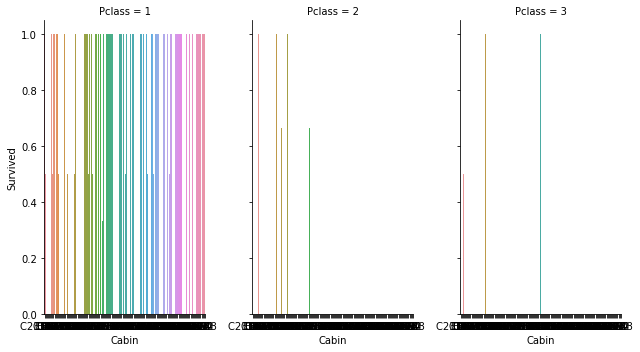

In [18]:
#Check survive rate by class and Sex (male, Female, Children)
sns.catplot(x="Cabin",y="Survived",col="Pclass",data=train_df
    , kind="bar", ci=None, aspect=.6)

In [34]:
train_df["In_cabin"]=train_df["Cabin"].apply(lambda x: 1 if x==x else 0 )

In [37]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_cat,Who,In_cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.,male,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,female,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,female,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,female,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.,male,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Poor.,male,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss.,female,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss.,female,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr.,male,1


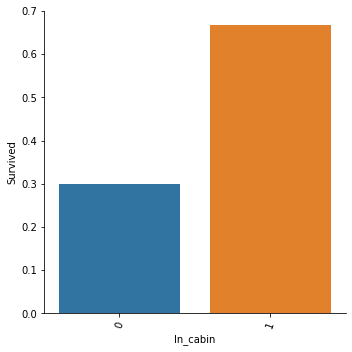

In [36]:
ax = sns.catplot(x="In_cabin",y="Survived",data=train_df
    , kind="bar", ci=None)
ax.set_xticklabels( rotation=70)


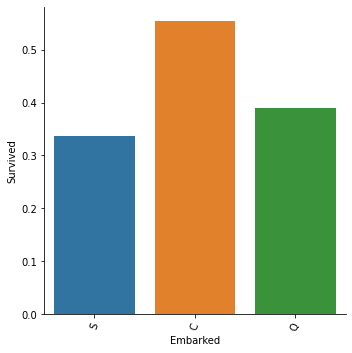

In [11]:
ax = sns.catplot(x="Embarked",y="Survived",data=train_df
    , kind="bar", ci=None)
ax.set_xticklabels( rotation=70)


### Test a dummy logistic regression model

In [38]:
train_df[0:2]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_cat,Who,In_cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.,male,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,female,1


In [39]:
train_df_m = train_df[["Survived","Fare","Pclass","Age","SibSp","Parch","Name_cat","Embarked","In_cabin"]].copy()
train_df_m

,Survived,Fare,Pclass,Age,SibSp,Parch,Name_cat,Embarked,In_cabin
0,0,7.2500,3,22.0,1,0,Mr.,S,0
1,1,71.2833,1,38.0,1,0,Mrs.,C,1
2,1,7.9250,3,26.0,0,0,Miss.,S,0
3,1,53.1000,1,35.0,1,0,Mrs.,S,1
4,0,8.0500,3,35.0,0,0,Mr.,S,0
...,...,...,...,...,...,...,...,...,...
886,0,13.0000,2,27.0,0,0,Poor.,S,0
887,1,30.0000,1,19.0,0,0,Miss.,S,1
888,0,23.4500,3,NaN,1,2,Miss.,S,0
889,1,30.0000,1,26.0,0,0,Mr.,C,1


In [40]:
ohe = OneHotEncoder(handle_unknown='ignore')
encode_df = pd.DataFrame(ohe.fit_transform(train_df_m[["Pclass","Name_cat","Embarked"]]).toarray())
final_df = train_df_m.join(encode_df)

In [41]:
final_df.drop(columns=["Pclass","Name_cat","Embarked"], inplace = True)
final_df

,Survived,Fare,Age,SibSp,Parch,In_cabin,0,1,2,3,...,5,6,7,8,9,10,11,12,13,14
0,0,7.2500,22.0,1,0,0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,71.2833,38.0,1,0,1,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,7.9250,26.0,0,0,0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,53.1000,35.0,1,0,1,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,8.0500,35.0,0,0,0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,13.0000,27.0,0,0,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
887,1,30.0000,19.0,0,0,1,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
888,0,23.4500,NaN,1,2,0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
889,1,30.0000,26.0,0,0,1,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Robust scaling on Fare

In [17]:
final_df[:10]

,Survived,Fare,Age,SibSp,Parch,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,7.2500,22.0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,71.2833,38.0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,7.9250,26.0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,53.1000,35.0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,8.0500,35.0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0,8.4583,NaN,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0,51.8625,54.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0,21.0750,2.0,3,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,1,11.1333,27.0,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1,30.0708,14.0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [42]:
X = final_df.loc[:, final_df.columns != "Survived"]
y = final_df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [44]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

r_scaler = RobustScaler()
mm_scaler = MinMaxScaler()
s_scaler = StandardScaler()

mean_of_train_age = X_train.Age.mean()
X_train.Age.fillna(mean_of_train_age, inplace=True)
X_test.Age.fillna(mean_of_train_age, inplace=True)

scaler = s_scaler.fit(X_train[["Age","SibSp","Parch"]])
X_train[["Age","SibSp","Parch"]] = scaler.transform(X_train[["Age","SibSp","Parch"]])
X_test[["Age","SibSp","Parch"]] =scaler.transform(X_test[["Age","SibSp","Parch"]])

scalaer_robust= r_scaler.fit(X_train[["Fare"]])
X_train[["Fare"]] = scalaer_robust.transform(X_train[["Fare"]])
X_test[["Fare"]] =scalaer_robust.transform(X_test[["Fare"]])



In [45]:
X_train

,Fare,Age,SibSp,Parch,In_cabin,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
138,-0.228811,-1.078074e+00,-0.462861,-0.468782,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
793,0.719361,-2.270344e-16,-0.462861,-0.468782,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
609,6.138771,8.062639e-01,-0.462861,-0.468782,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.708372,4.136934e-01,0.432675,-0.468782,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
278,0.650020,-1.784701e+00,3.119282,0.753829,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,0.059228,-2.255786e+00,-0.462861,1.976441,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
451,0.245736,-2.270344e-16,0.432675,-0.468782,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,1.653744,1.905461e+00,-0.462861,-0.468782,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
820,3.491788,1.748433e+00,0.432675,0.753829,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


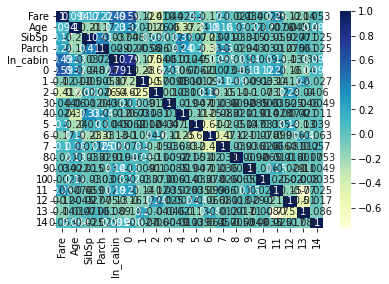

In [46]:
dataplot = sns.heatmap(X_train.corr(), cmap="YlGnBu", annot=True)


In [48]:
model = LogisticRegression()
cv_results = cross_validate(model, X_train,y_train,cv=5)
result = cv_results["test_score"].mean()
print(f"resultat de la moyenne des cross validation : {result}")

resultat de la moyenne des cross validation : 0.8427853836304541


/Users/christopherdeboisvilliers/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/christopherdeboisvilliers/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/christopherdeboisvilliers/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/christopherdeboisvilliers/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature nam

/Users/christopherdeboisvilliers/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/christopherdeboisvilliers/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/christopherdeboisvilliers/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/christopherdeboisvilliers/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature nam

<AxesSubplot:>

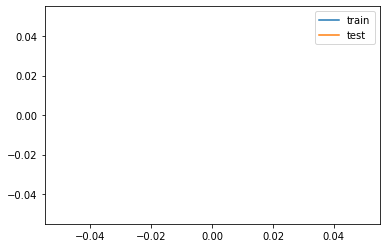

In [49]:
train_sizes = [1,25,50,100,150,200,300,400,500,712]
train_sizes, train_scores, test_scores = learning_curve(estimator = LogisticRegression(max_iter=1000),X=X,y=y,\
                train_sizes=train_sizes, cv=10)
train_scores_mean = np.mean(train_scores,axis=1)
test_scores_mean = np.mean(test_scores,axis=1)
sns.lineplot(train_sizes, train_scores_mean, label="train")
sns.lineplot(train_sizes, test_scores_mean, label="test")

#### Check deep learning to predict class survived or not

In [50]:
# Tensorflow for machine learning
# import tensorflow as tf
import swifter
# Numpy and pandas for dataset manipulation
import numpy as np
import pandas as pd
#Seaborn and matplotlib to make graphics 
import seaborn as sns
import matplotlib.pyplot as plt

#Skelarn metrics to get confusion matrix and classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Shuffle sklearn lib to  mixing train dataset X and y
from sklearn.utils import shuffle

In [51]:
def plot_get_conf_learning(model,history, X_test, y_test ):
    
    # Predict class for X_test
    predictions = model.predict(X_test)
    # Affect class
    y_mean_pred = [1 * (x[0]>=0.5) for x in predictions]
    # Create confusion matrix
    cf_matrix = confusion_matrix( y_test, y_mean_pred)

    #Create subplot
    fig, axes = plt.subplots(1, 2,  figsize=(15,4))

    # Confusion matrix plotting
    axes[0].set_title(' Confusion Matrix with labels\n\n');
    sns.heatmap(ax =axes[0], data = cf_matrix, annot=True, cmap='Reds')


    # Learning curves plotting
    loss = history.history["loss"]
    loss_val = history.history["val_loss"]
    sns.lineplot(ax=axes[1],data =[loss,loss_val])
    axes[1].set_title('Learning curves \n\n')
    axes[1].legend(labels=["Train set","Test set"], title = "Learning curves")
    
    #Print classification report
    print(classification_report(y_test, y_mean_pred))
    #Show graphics
    return plt.show()

In [54]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import RMSprop

def init_model():
    # opt = RMSprop(lr=0.0001, decay=1e-6)
    model = models.Sequential()
    neurons = 8
    model.add(layers.Dense(8, activation='linear'))
    model.add(layers.Dropout(0.01))
    model.add(layers.Dense(4, activation='linear', kernel_regularizer='l1'))
    model.add(layers.Dropout(0.01))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer="adam", 
                  metrics=['accuracy'])
    return model

In [55]:
# Impor tensorflow early stopping callback to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping

# Define the mode@l
model_mean_v1 = init_model()
#Define early stopping parmaters
es = EarlyStopping(patience=600, restore_best_weights=True,monitor='val_loss')

#Start training the neural network
history_mean_v1 = model_mean_v1.fit(X_train, y_train, 
          epochs=2000, 
          batch_size=2, 
          verbose=1, 
          callbacks=es,
          validation_split=0.15)

Epoch 1/2000
303/303 [==============================] - 1s 954us/step - loss: 0.9700 - accuracy: 0.6132 - val_loss: 0.5971 - val_accuracy: 0.8037
Epoch 2/2000
303/303 [==============================] - 0s 769us/step - loss: 0.6008 - accuracy: 0.7702 - val_loss: 0.5073 - val_accuracy: 0.8692
Epoch 3/2000
303/303 [==============================] - 0s 665us/step - loss: 0.5396 - accuracy: 0.8198 - val_loss: 0.4934 - val_accuracy: 0.8505
Epoch 4/2000
303/303 [==============================] - 0s 587us/step - loss: 0.5214 - accuracy: 0.8264 - val_loss: 0.4837 - val_accuracy: 0.8224
Epoch 5/2000
303/303 [==============================] - 0s 541us/step - loss: 0.5036 - accuracy: 0.8331 - val_loss: 0.4858 - val_accuracy: 0.8411
Epoch 6/2000
303/303 [==============================] - 0s 569us/step - loss: 0.5023 - accuracy: 0.8364 - val_loss: 0.4868 - val_accuracy: 0.8411
Epoch 7/2000
303/303 [==============================] - 0s 552us/step - loss: 0.4958 - accuracy: 0.8331 - val_loss: 0.4858 -

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       107
           1       0.78      0.68      0.73        72

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



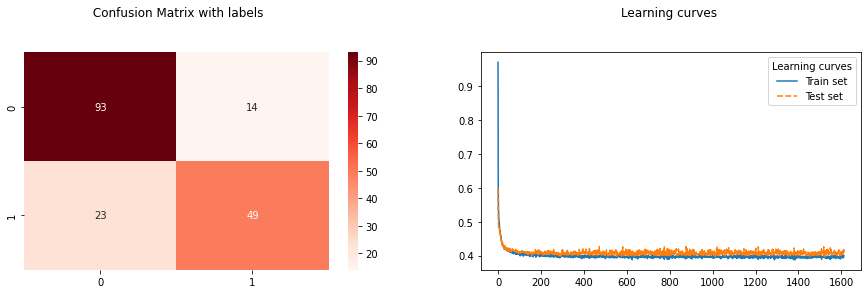

In [56]:
plot_get_conf_learning(model_mean_v1,history_mean_v1,X_test, y_test)

In [57]:
X_train

,Fare,Age,SibSp,Parch,In_cabin,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
138,-0.228811,-1.078074e+00,-0.462861,-0.468782,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
793,0.719361,-2.270344e-16,-0.462861,-0.468782,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
609,6.138771,8.062639e-01,-0.462861,-0.468782,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.708372,4.136934e-01,0.432675,-0.468782,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
278,0.650020,-1.784701e+00,3.119282,0.753829,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,0.059228,-2.255786e+00,-0.462861,1.976441,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
451,0.245736,-2.270344e-16,0.432675,-0.468782,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,1.653744,1.905461e+00,-0.462861,-0.468782,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
820,3.491788,1.748433e+00,0.432675,0.753829,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Decision tree classifier model

In [58]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=2)
tree_clf.fit(X_train,y_train)
tree_clf.score(X_test, y_test)

0.7653631284916201

In [63]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=42, learning_rate=1,
     max_depth=2, random_state=4
     ).fit(X_train, y_train)
clf.score(X_test, y_test)


0.7597765363128491

In [60]:
from sklearn.linear_model import SGDClassifier
svc_bis = SGDClassifier(loss='hinge', penalty='l2')
svc_bis.fit(X_train, y_train)
svc_bis.score(X_test, y_test)

0.7150837988826816

In [ ]:
0.8483108440854921
{'learning_rate': 1, 'max_depth': 2, 'n_estimators': 42}

In [61]:
from sklearn.model_selection import GridSearchCV

# Train/Test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Instanciate model
model = GradientBoostingClassifier()
# Hyperparameter Grid
n_estimators = [i for i  in range(2,50,5)]
max_depth =[i for i  in range(2,50,5)]

grid = {'n_estimators': n_estimators, 
        'learning_rate': [0.1,0.3,0.5,0.8,1,2],
        'max_depth':max_depth
        }

# Instanciate Grid Search
search = GridSearchCV(model, grid, 
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs=-1 # paralellize computation
                          ) 

# Fit data to Grid Search
search.fit(X_train,y_train);

/Users/christopherdeboisvilliers/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/christopherdeboisvilliers/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/christopherdeboisvilliers/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/christopherdeboisvilliers/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature nam

In [62]:
# Best score
print(search.best_score_)

# Best Params
print(search.best_params_)

# Best estimator
print(search.best_estimator_)

0.8483108440854921
{'learning_rate': 1, 'max_depth': 2, 'n_estimators': 42}
GradientBoostingClassifier(learning_rate=1, max_depth=2, n_estimators=42)
